In [1]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
#from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import train_test_split
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Initialise the data

In [2]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

SEED = 42

random.seed(SEED)
tf.set_random_seed(SEED)

np.random.shuffle(train_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

Image: <PIL.Image.Image image mode=RGB size=64x64 at 0x7F5D6DCB6BD0>
Lable: [0.0, 1.0]


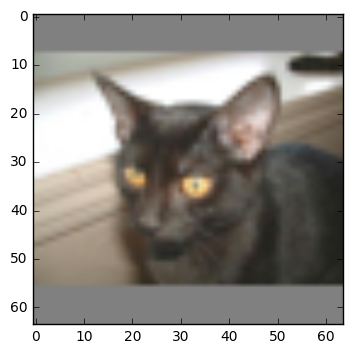

In [3]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print 'Image:', (processed_image)
print 'Lable:', (labels[random_index])
plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [4]:
print 'Image shape:', (np.array(processed_image).shape)

Image shape: (64, 64, 3)


In [5]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [6]:
from multiprocessing import Pool
import math

In [7]:
dataset_size = 25000
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print 'Training picture shape:', train[0].shape
print 'Numbers of training pictures and labels:', len(train), len(labels)

Training picture shape: (64, 64, 3)
Numbers of training pictures and labels: 25000 25000


In [8]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, step=1e-4, size=64, batch_size=100, l1_lambda=0.5, l2_lambda=0.5):
        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        
        with tf.contrib.framework.arg_scope([layers.convolution2d],
            kernel_size=3, stride=1, rate=1, padding='SAME', activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(seed=SEED),
            weights_regularizer=layers.l2_regularizer(l2_lambda)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)

            net = layers.convolution2d(self.X, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=32)

            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=64)
            
            net = layers.convolution2d(net, num_outputs=128)
            net = layers.convolution2d(net, num_outputs=128)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=128)
            
            net = layers.convolution2d(net, num_outputs=256)
            net = layers.convolution2d(net, num_outputs=256)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=256)
            
            net = layers.convolution2d(net, num_outputs=512)
            net = layers.convolution2d(net, num_outputs=512)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=512)
            
        with tf.contrib.framework.arg_scope([layers.fully_connected],
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(seed=SEED),
            weights_regularizer=layers.l2_regularizer(l2_lambda)
        ):

            net = layers.flatten(net, [-1, 2 * 2* 512])
            net = layers.fully_connected(net, num_outputs=64)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            
        net = layers.fully_connected(net, num_outputs=self.class_num)
        self.y = layers.softmax(net)

        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.AdamOptimizer(step, beta1=0.8).minimize(self.loss)

        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, iterations=2000, keep_prob=0.5, metric_batch_size=512):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())

        batch_size = self.batch_size

        batch_start = 0
        batch_end = batch_start + batch_size

        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)

        epoch = 0
        for iteration in range(int(iterations)):
            self.sess.run(
                self.optimizer,
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )

            if iteration % 1000 == 0:   
                val_acc, val_loss = self.__get_scores(X_test, y_test, metric_batch_size)
                tr_acc, tr_loss = self.__get_scores(X_train, y_train, metric_batch_size)

                print(
                    '{}({}):, tr_acc: {:.2%}, tr_loss: {:2.6}, val_acc: {:.2%}, val_loss: {:2.5}'.format(
                        iteration, epoch,  tr_acc, tr_loss, val_acc, val_loss)
                )

                if val_loss <= 0.1:
                    print('Validation loss is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                epoch += 1
                batch_start = 0
                batch_end = batch_start + batch_size

                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")
        
    def __get_scores(self, X_test, y_test, metric_batch_size):
        losses = []
        accs = []
        for chunk in range(0, len(X_test), metric_batch_size):

            start_index = chunk
            end_index = chunk + metric_batch_size

            batch_X = X_test[start_index:end_index]
            batch_y = y_test[start_index:end_index]

            batch_val_acc, batch_val_loss = self.sess.run(
                [self.acc, self.loss],
                feed_dict={
                    self.X: batch_X,
                    self.y_: batch_y,
                    self.keep_prob: 1.0}
            )
            
            losses.append(batch_val_loss)
            accs.append(batch_val_acc)
        
        return np.mean(accs), np.mean(losses)
        
    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = self.y

        predictions = []
        for i in range(0, len(test_x)):

            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]

            if len(batch) == 0:
                break
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})
            predict_batch = map(lambda x: x[0], predict_batch[0])
            predictions.extend(list(predict_batch))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d,%f'
        )

        print('saved: %s' % file_name)
        
    def predict(self, X):
        image = Preprocessor.get_image(X)
        processed_image = Preprocessor.get_processed_image(image, size=image_size)
        
        plt.imshow(processed_image)
        plt.show()
        
        X_processed = np.array(processed_image).reshape([-1, image_size, image_size, 3])
        predict = self.sess.run([self.y], feed_dict={self.X: X_processed, self.keep_prob: 1.0})
        
        prediction = predict[0][0]
        print prediction
        print 'I think it is a {creature}.'.format(
            creature='dog' if prediction[0] > prediction[1] else 'cat'
        )

# Initialise the model and train

In [9]:
class_num = 2
feature_number = image_size * image_size * 3

train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.2)  

In [10]:
convnet = TFConvNet(
    feature_number,
    class_num,
    size=image_size,
    batch_size=16,
    step=5e-4, 
    l1_lambda=0.0,
    l2_lambda=350.0
)

In [11]:
try:
    convnet.train(
        train_x,
        train_y,
        test_x,
        test_y,
        iterations=2e5,
        keep_prob=0.35,
        metric_batch_size=32
    )
except KeyboardInterrupt:
    print "Training stopped!"

Starting to train


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: Conv_9/weights/Initializer/truncated_normal/mul = Mul[T=DT_FLOAT, _class=["loc:@Conv_9/weights"], _device="/job:localhost/replica:0/task:0/gpu:0"](Conv_9/weights/Initializer/truncated_normal/TruncatedNormal, Conv_9/weights/Initializer/truncated_normal/stddev)]]

Caused by op u'Conv_9/weights/Initializer/truncated_normal/mul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-e1527ea096a0>", line 8, in <module>
    l2_lambda=350.0
  File "<ipython-input-8-ebf9db01c067>", line 44, in __init__
    net = layers.convolution2d(net, num_outputs=512)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 433, in convolution2d
    trainable=trainable)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/variables.py", line 269, in model_variable
    caching_device=caching_device, device=device)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/framework/python/ops/variables.py", line 233, in variable
    caching_device=caching_device)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 1022, in get_variable
    custom_getter=custom_getter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 849, in get_variable
    custom_getter=custom_getter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 345, in get_variable
    validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 330, in _true_getter
    caching_device=caching_device, validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 676, in _get_single_variable
    validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 215, in __init__
    dtype=dtype)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 288, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variable_scope.py", line 666, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/layers/python/layers/initializers.py", line 138, in _initializer
    seed=seed)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/random_ops.py", line 176, in truncated_normal
    mul = rnd * stddev_tensor
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 751, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 910, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1519, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: Conv_9/weights/Initializer/truncated_normal/mul = Mul[T=DT_FLOAT, _class=["loc:@Conv_9/weights"], _device="/job:localhost/replica:0/task:0/gpu:0"](Conv_9/weights/Initializer/truncated_normal/TruncatedNormal, Conv_9/weights/Initializer/truncated_normal/stddev)]]


# Model generalization exploration

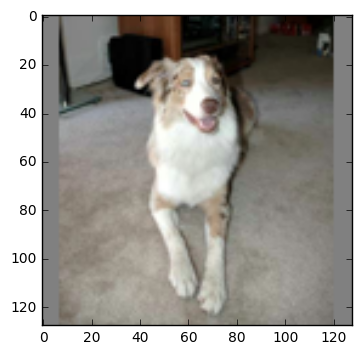

[ 0.70509267  0.2949073 ]
I think it is a dog.


In [19]:
for i in range(1):
    random_index = np.random.randint(0, len(train_all))
    image_path = train_all[random_index]
    convnet.predict(image_path)

# Process test data

In [20]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [21]:
print 'Test image shape:', test[0].shape

Test image shape: (128, 128, 3)


In [22]:
print test_all[:3]

['../dataset/test/1.jpg', '../dataset/test/2.jpg', '../dataset/test/3.jpg']


# Generate submission

In [23]:
convnet.generate_submission(test)

Preparing to generate submission.csv
(12500, 12500)
saved: submission.csv
